In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

In [ ]:
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv('BeritaBohongUjaranKebenciandanOfensifgubernurDKIAHOK.csv')
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df.shape

(24783, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


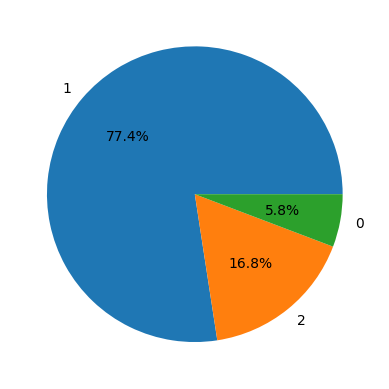

In [ ]:
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

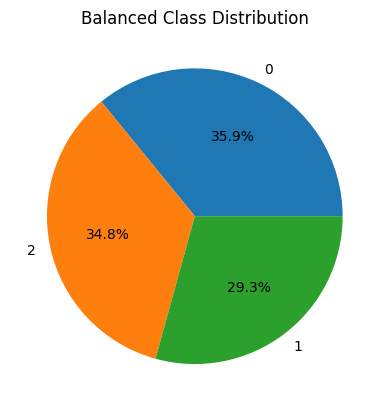

In [ ]:
class_0 = df[df['class'] == 0]  # Hate Speech
class_1 = df[df['class'] == 1].sample(n=3500, random_state=42)  # Offensive Language
class_2 = df[df['class'] == 2]  # Neutral

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

# Visualize the balanced distribution
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Balanced Class Distribution")
plt.show()

In [ ]:
df['tweet'] = df['tweet'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()


,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,1,rt cganderson vivabased she look like a tranny
4,1,rt shenikaroberts the shit you hear about me ...


In [ ]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

balanced_df['tweet'] = balanced_df['tweet'].apply(preprocess_text)

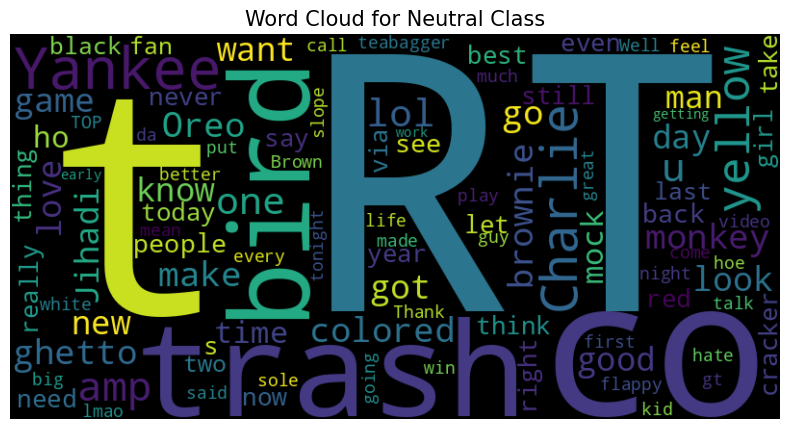

In [ ]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['tweet'])
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} Class", fontsize=15)
    plt.show()

plot_word_cloud(balanced_df[balanced_df['class'] == 2], typ="Neutral")


In [ ]:
features = balanced_df['tweet']
target = balanced_df['class']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

max_words = 10000
max_len = 100

model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(None, max_len))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,755 (1.32 MB)

 Trainable params: 345,731 (1.32 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

In [ ]:
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.6622 - loss: 3.8461 - val_accuracy: 0.6512 - val_loss: 0.9758 - learning_rate: 0.0010
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.9105 - loss: 0.3598 - val_accuracy: 0.8871 - val_loss: 0.4499 - learning_rate: 0.0010
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.9469 - loss: 0.2461 - val_accuracy: 0.8913 - val_loss: 0.4086 - learning_rate: 0.0010
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9616 - loss: 0.1854 - val_accuracy: 0.8210 - val_loss: 0.5682 - learning_rate: 0.0010
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.9631 - loss: 0.1727 - val_accuracy: 0.8687 - val_loss: 0.5339 - learning_rate: 0.0010
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.9775 - loss: 0.1185 - val_accuracy: 0.9038 - val_loss: 0.4038 - learning_rate: 5.0000e-04
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.9847

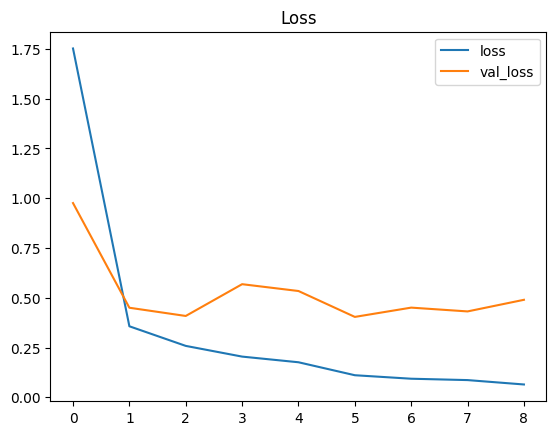

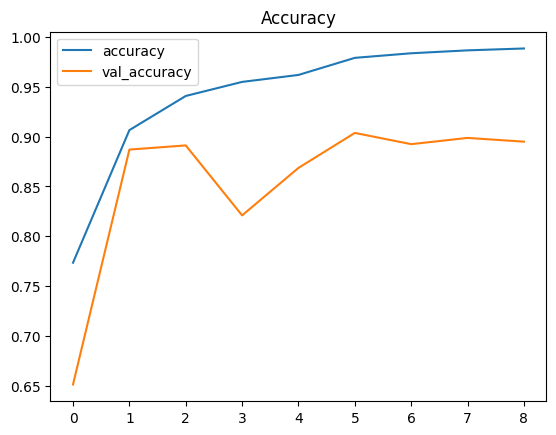

In [ ]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss")

history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_val_padded, Y_val)
print(f"Validation Accuracy: {test_acc:.2f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9051 - loss: 0.3907
Validation Accuracy: 0.90
